In [1]:
import cv2
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and configured.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Training on CPU.")

GPU is available and configured.


In [3]:
import os
os.environ['TF_XLA_FLAGS'] = '--xla_gpu_enable_async_eigen=false'

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import layers, models
import cv2
import os

In [5]:
def preprocess_image(image):
    image_array = np.array(image)
    image_bgr = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
    image_resized = cv2.resize(image_bgr, (224, 224))
    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_applied = clahe.apply(gray)
    image_final = cv2.merge([clahe_applied, clahe_applied, clahe_applied])

    return image_final

In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence

In [7]:
class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, 
                 image_directory=None, 
                 validation_split=0.15,  
                 target_size=(224, 224), 
                 batch_size=32,
                 exclude_labels=None,  
                 isSplit=False,
                 **kwargs):
        """
        Initialize the generator with optional image directory and validation split.
        
        Args:
            image_directory (str, optional): Root directory containing image folders.
            validation_split (float, optional): Proportion of data to reserve for validation.
            target_size (tuple): Image resize dimensions.
            batch_size (int): Number of images per batch.
            exclude_labels (list, optional): Labels to exclude from processing.
            **kwargs: Additional arguments passed to ImageDataGenerator.
        """
        self.validation_split = validation_split
        self.image_directory = image_directory
        self.target_size = target_size
        self.batch_size = batch_size
        self.exclude_labels = exclude_labels or []

        super().__init__(validation_split=validation_split, **kwargs)

        self.image_paths = []
        self.labels = []
        self.crop_names = []
        self.isSplit = isSplit

        self.train_image_paths = []
        self.val_image_paths = []
        self.train_labels = []
        self.val_labels = []
        self.train_crop_names = []
        self.val_crop_names = []

        self.label_encoder = None
        self.crop_encoder = None
        self.onehot_crop_encoder = None

        if self.image_directory:
            self._prepare_data()

    def _prepare_data(self):
        """Collect image paths and labels from directory."""
        for root, _, files in os.walk(self.image_directory):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    path = os.path.join(root, file)
                    label = os.path.basename(root)
                    crop_name = label.split('__')[0]  

                    if crop_name not in self.exclude_labels:
                        self.image_paths.append(path)
                        self.labels.append(label)
                        self.crop_names.append(crop_name) 

        unique_labels = np.unique(self.labels)
        self._initialize_encoders()
        if self.isSplit:
            self._split_data()

    def _initialize_encoders(self):
        """Initialize label and crop encoders."""
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)

        self.crop_encoder = LabelEncoder()
        self.crop_encoder.fit(self.crop_names)

        # One-hot Crop Encoder
        self.onehot_crop_encoder = OneHotEncoder(sparse_output=False)
        crop_encoded = self.crop_encoder.transform(self.crop_names).reshape(-1, 1)
        self.onehot_crop_encoder.fit(crop_encoded)

    def _split_data(self):
        """Split data into train and validation sets."""
        self.train_image_paths, self.val_image_paths, \
        self.train_labels, self.val_labels, \
        self.train_crop_names, self.val_crop_names = train_test_split(
            self.image_paths,
            self.labels,
            self.crop_names,
            test_size=self.validation_split,
            stratify=self.labels,
            random_state=42
        )

    def flow_from_directory(self, 
                         directory=None, 
                         subset=None, 
                         class_mode='categorical', 
                         preprocessing_function=preprocess_image,  
                         **kwargs):
        """
        Custom flow method for generating batches with preprocessing.
        
        Args:
            directory (str, optional): Directory containing images.
            subset (str, optional): 'training' or 'validation'.
            class_mode (str): How to encode labels.
            preprocessing_function (callable, optional): Function to preprocess each image.
            **kwargs: Additional arguments for ImageDataGenerator flow.
        
        Returns:
            A generator yielding batches of preprocessed images and labels.
        """
        directory = directory or self.image_directory
        
        if subset == 'training':
            image_paths, labels, crop_names = self.train_image_paths, self.train_labels, self.train_crop_names
        elif subset == 'validation':
            image_paths, labels, crop_names = self.val_image_paths, self.val_labels, self.val_crop_names
        else:
            image_paths, labels, crop_names = self.image_paths, self.labels, self.crop_names
    
        while True:
            indices = np.arange(len(image_paths))
            np.random.shuffle(indices)
            
            image_paths = [image_paths[i] for i in indices]
            labels = [labels[i] for i in indices]
            crop_names = [crop_names[i] for i in indices]
    
            for i in range(0, len(image_paths), self.batch_size):
                batch_image_paths = image_paths[i:i + self.batch_size]
                batch_labels = labels[i:i + self.batch_size]
                batch_crop_names = crop_names[i:i + self.batch_size]
    
                images = []
                for path in batch_image_paths:
                    img = load_img(path, target_size=self.target_size)
    
                    if preprocessing_function:
                        img = preprocessing_function(img)
                    else:
                        img = img_to_array(img) / 255.0                        
    
                    images.append(img)
                images = np.array(images)
    
                encoded_labels = to_categorical(self.label_encoder.transform(batch_labels), 
                                                num_classes=len(self.label_encoder.classes_))
                crop_encoded = self.crop_encoder.transform(batch_crop_names).reshape(-1, 1)
                crop_onehot = self.onehot_crop_encoder.transform(crop_encoded)
    
                yield (images, crop_onehot), encoded_labels


    def get_label_mappings(self):
        """Retrieve label and crop encodings."""
        return {
            'label_encoder': self.label_encoder,
            'crop_encoder': self.crop_encoder,
            'label_to_index': dict(zip(self.label_encoder.classes_, range(len(self.label_encoder.classes_)))),
            'crop_to_index': dict(zip(self.crop_encoder.classes_, range(len(self.crop_encoder.classes_))))
        }


In [8]:
exclude_classes = ['Blueberry', 'Orange', 'Raspberry', 'Soybean', 'Squash']


In [9]:
train_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/'
test_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/'

batch_size = 32
target_size = (224, 224)

train_gen = CustomImageDataGenerator(
    image_directory=train_dir,
    validation_split=0.2,  
    target_size=target_size,
    batch_size=batch_size,
    exclude_labels=exclude_classes,
    rescale=1.0/255,  
    isSplit=True
)

train_generator = train_gen.flow_from_directory(
    subset='training',
    class_mode='categorical',
    preprocessing_function=preprocess_image
)

val_generator = train_gen.flow_from_directory(
    subset='validation',
    class_mode='categorical',
    preprocessing_function=preprocess_image
)

test_gen = CustomImageDataGenerator(
    image_directory=test_dir,
    target_size=target_size,
    batch_size=batch_size,
    exclude_labels=exclude_classes,
    rescale=1.0/255, 
    isSplit=False
)

test_generator = test_gen.flow_from_directory(
    subset=None,  
    class_mode='categorical', 
    preprocessing_function=preprocess_image
)

In [10]:
print(f"Training images: {len(train_gen.train_image_paths)}")
print(f"Validation images: {len(train_gen.val_image_paths)}")
print(f"Test images: {len(test_gen.image_paths)}")

Training images: 48744
Validation images: 12186
Test images: 15231


In [11]:
print(f"first image path train: {train_gen.train_image_paths[:5]}\nfirst image label: {train_gen.train_labels[:5]} and crop was {train_gen.train_crop_names[:5]}")
print(f"first image path valid: {train_gen.val_image_paths[:5]}\nfirst image label: {train_gen.val_labels[:5]} and crop was {train_gen.val_crop_names[:5]}")
print(f"first image path test: {test_gen.image_paths[1000:1005]}\nfirst image label: {test_gen.labels[1000:1005]} and crop was {test_gen.crop_names[1000:1005]}")

first image path train: ['/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Potato___Late_blight/75fd327f-c30c-4b73-b7a1-fd11aab8206e___RS_LB 2508.JPG', '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Pepper,_bell___healthy/9cde7a11-a044-4ca6-b1f1-4507b867f915___JR_HL 8580.JPG', '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Black_rot/5db69c6b-f9c9-4a3f-b47a-ca6449023bdd___JR_FrgE.S 2757.JPG', '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Cedar_apple_rust/5367e167-14f3-4d65-bd93-4c4b693e0bc7___FREC_C.Rust 4109_180deg.JPG', '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Grape___Black_rot/fa7dafca-

In [12]:
train_gen.get_label_mappings()

{'label_encoder': LabelEncoder(),
 'crop_encoder': LabelEncoder(),
 'label_to_index': {'Apple___Apple_scab': 0,
  'Apple___Black_rot': 1,
  'Apple___Cedar_apple_rust': 2,
  'Apple___healthy': 3,
  'Cherry_(including_sour)___Powdery_mildew': 4,
  'Cherry_(including_sour)___healthy': 5,
  'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 6,
  'Corn_(maize)___Common_rust_': 7,
  'Corn_(maize)___Northern_Leaf_Blight': 8,
  'Corn_(maize)___healthy': 9,
  'Grape___Black_rot': 10,
  'Grape___Esca_(Black_Measles)': 11,
  'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 12,
  'Grape___healthy': 13,
  'Peach___Bacterial_spot': 14,
  'Peach___healthy': 15,
  'Pepper,_bell___Bacterial_spot': 16,
  'Pepper,_bell___healthy': 17,
  'Potato___Early_blight': 18,
  'Potato___Late_blight': 19,
  'Potato___healthy': 20,
  'Strawberry___Leaf_scorch': 21,
  'Strawberry___healthy': 22,
  'Tomato___Bacterial_spot': 23,
  'Tomato___Early_blight': 24,
  'Tomato___Late_blight': 25,
  'Tomato___Leaf_Mold': 26,
 

In [13]:
test_gen.get_label_mappings()

{'label_encoder': LabelEncoder(),
 'crop_encoder': LabelEncoder(),
 'label_to_index': {'Apple___Apple_scab': 0,
  'Apple___Black_rot': 1,
  'Apple___Cedar_apple_rust': 2,
  'Apple___healthy': 3,
  'Cherry_(including_sour)___Powdery_mildew': 4,
  'Cherry_(including_sour)___healthy': 5,
  'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 6,
  'Corn_(maize)___Common_rust_': 7,
  'Corn_(maize)___Northern_Leaf_Blight': 8,
  'Corn_(maize)___healthy': 9,
  'Grape___Black_rot': 10,
  'Grape___Esca_(Black_Measles)': 11,
  'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 12,
  'Grape___healthy': 13,
  'Peach___Bacterial_spot': 14,
  'Peach___healthy': 15,
  'Pepper,_bell___Bacterial_spot': 16,
  'Pepper,_bell___healthy': 17,
  'Potato___Early_blight': 18,
  'Potato___Late_blight': 19,
  'Potato___healthy': 20,
  'Strawberry___Leaf_scorch': 21,
  'Strawberry___healthy': 22,
  'Tomato___Bacterial_spot': 23,
  'Tomato___Early_blight': 24,
  'Tomato___Late_blight': 25,
  'Tomato___Leaf_Mold': 26,
 

In [14]:
def check_class_distribution(custom_generator, type="Train"):
    """
    Function to check and visualize class distribution for a CustomImageDataGenerator instance.
    Args:
        custom_generator (CustomImageDataGenerator): Instance of CustomImageDataGenerator class.
    """
    if type == "Train":
        labels = custom_generator.train_labels 
    elif type == "Valid":
        labels = custom_generator.val_labels
    else:
        labels = custom_generator.labels
    
    label_counts = Counter(labels)
    
    class_names = list(label_counts.keys())
    class_frequencies = list(label_counts.values())
    
    plt.figure(figsize=(15, 5))
    plt.bar(class_names, class_frequencies, color='skyblue')
    plt.xlabel('Class Names')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution in Dataset')
    plt.xticks(rotation=90)
    plt.show()
    
    for class_name, count in label_counts.items():
        print(f"Class: {class_name}, Count: {count}")

Data distribution for train data

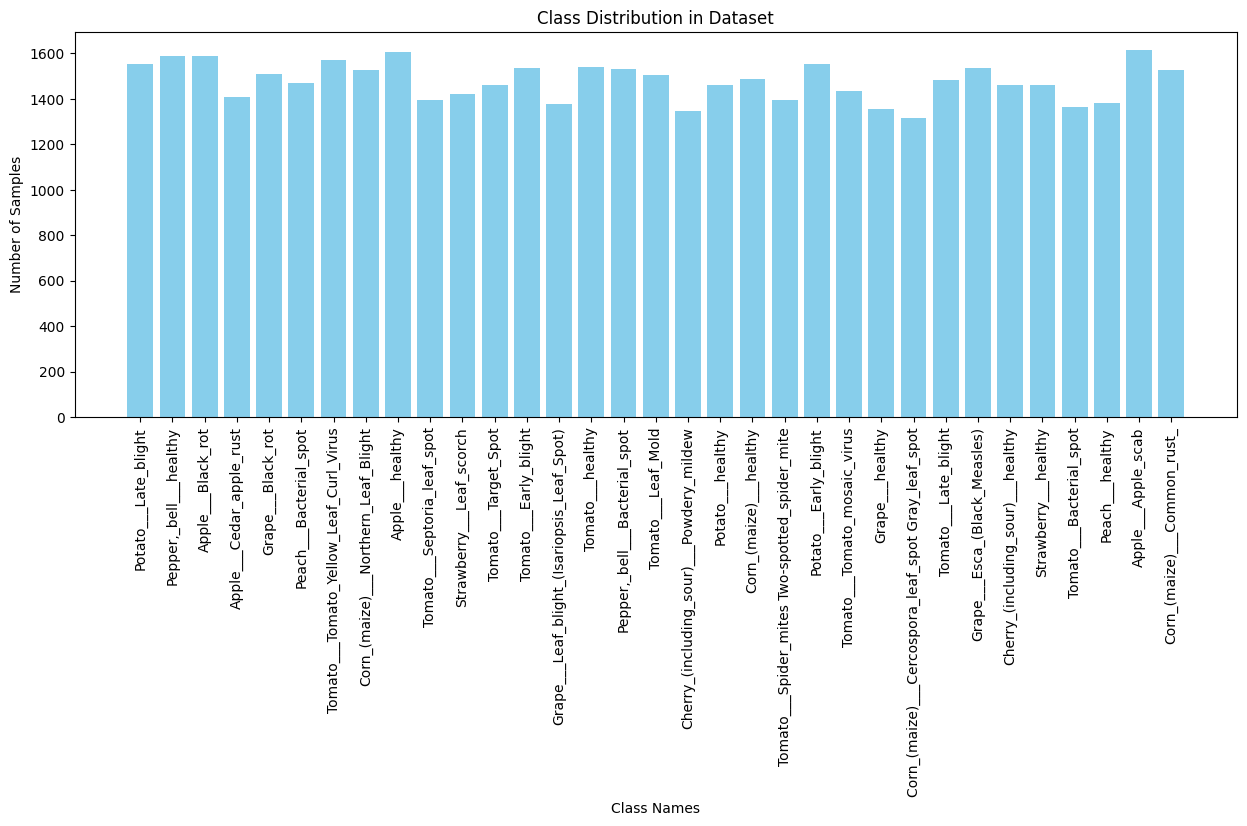

Class: Potato___Late_blight, Count: 1551
Class: Pepper,_bell___healthy, Count: 1590
Class: Apple___Black_rot, Count: 1590
Class: Apple___Cedar_apple_rust, Count: 1408
Class: Grape___Black_rot, Count: 1510
Class: Peach___Bacterial_spot, Count: 1470
Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, Count: 1569
Class: Corn_(maize)___Northern_Leaf_Blight, Count: 1526
Class: Apple___healthy, Count: 1606
Class: Tomato___Septoria_leaf_spot, Count: 1396
Class: Strawberry___Leaf_scorch, Count: 1419
Class: Tomato___Target_Spot, Count: 1462
Class: Tomato___Early_blight, Count: 1536
Class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), Count: 1378
Class: Tomato___healthy, Count: 1541
Class: Pepper,_bell___Bacterial_spot, Count: 1530
Class: Tomato___Leaf_Mold, Count: 1506
Class: Cherry_(including_sour)___Powdery_mildew, Count: 1346
Class: Potato___healthy, Count: 1459
Class: Corn_(maize)___healthy, Count: 1487
Class: Tomato___Spider_mites Two-spotted_spider_mite, Count: 1393
Class: Potato___Early_blight,

In [15]:
check_class_distribution(train_gen)

Data Distribution for validation data

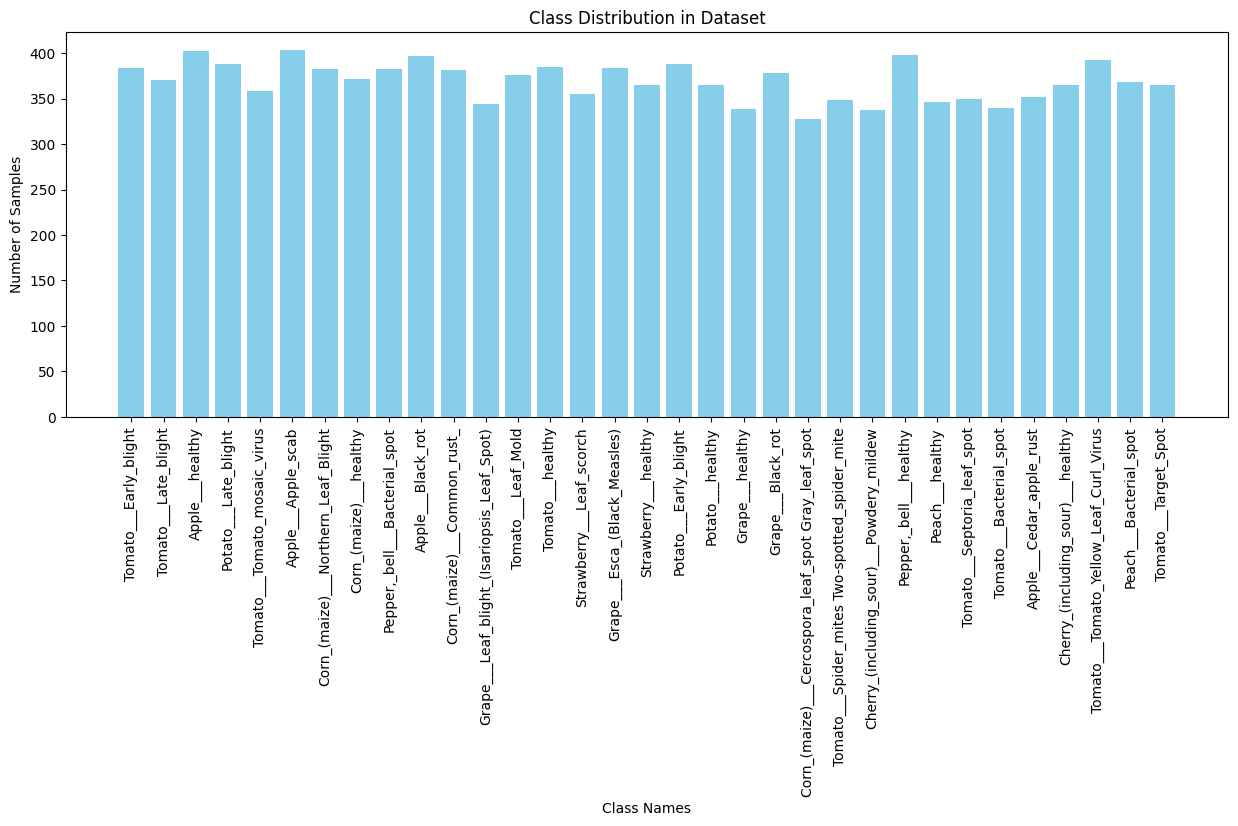

Class: Tomato___Early_blight, Count: 384
Class: Tomato___Late_blight, Count: 370
Class: Apple___healthy, Count: 402
Class: Potato___Late_blight, Count: 388
Class: Tomato___Tomato_mosaic_virus, Count: 358
Class: Apple___Apple_scab, Count: 403
Class: Corn_(maize)___Northern_Leaf_Blight, Count: 382
Class: Corn_(maize)___healthy, Count: 372
Class: Pepper,_bell___Bacterial_spot, Count: 383
Class: Apple___Black_rot, Count: 397
Class: Corn_(maize)___Common_rust_, Count: 381
Class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), Count: 344
Class: Tomato___Leaf_Mold, Count: 376
Class: Tomato___healthy, Count: 385
Class: Strawberry___Leaf_scorch, Count: 355
Class: Grape___Esca_(Black_Measles), Count: 384
Class: Strawberry___healthy, Count: 365
Class: Potato___Early_blight, Count: 388
Class: Potato___healthy, Count: 365
Class: Grape___healthy, Count: 338
Class: Grape___Black_rot, Count: 378
Class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot, Count: 328
Class: Tomato___Spider_mites Two-spotted_

In [16]:
check_class_distribution(train_gen, type="Valid")

Distribution for test data

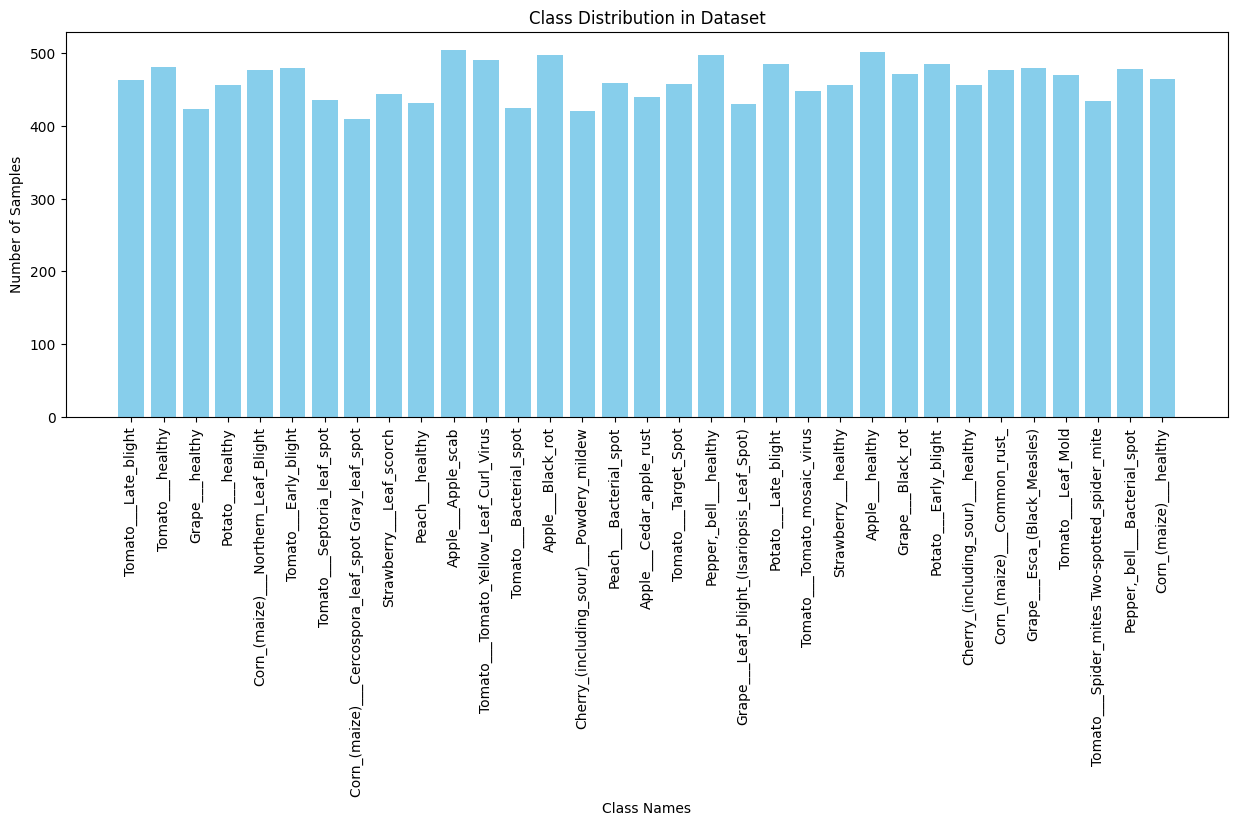

Class: Tomato___Late_blight, Count: 463
Class: Tomato___healthy, Count: 481
Class: Grape___healthy, Count: 423
Class: Potato___healthy, Count: 456
Class: Corn_(maize)___Northern_Leaf_Blight, Count: 477
Class: Tomato___Early_blight, Count: 480
Class: Tomato___Septoria_leaf_spot, Count: 436
Class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot, Count: 410
Class: Strawberry___Leaf_scorch, Count: 444
Class: Peach___healthy, Count: 432
Class: Apple___Apple_scab, Count: 504
Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, Count: 490
Class: Tomato___Bacterial_spot, Count: 425
Class: Apple___Black_rot, Count: 497
Class: Cherry_(including_sour)___Powdery_mildew, Count: 421
Class: Peach___Bacterial_spot, Count: 459
Class: Apple___Cedar_apple_rust, Count: 440
Class: Tomato___Target_Spot, Count: 457
Class: Pepper,_bell___healthy, Count: 497
Class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), Count: 430
Class: Potato___Late_blight, Count: 485
Class: Tomato___Tomato_mosaic_virus, Count: 448
Class: 

In [17]:
check_class_distribution(test_gen, type="Test")

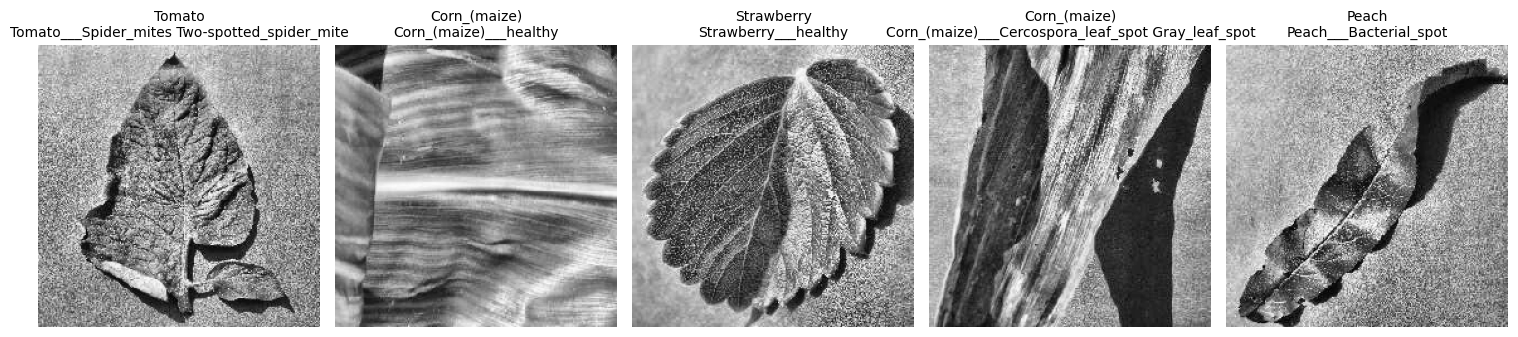

In [18]:
label_mappings = train_gen.get_label_mappings()
index_to_label = {v: k for k, v in label_mappings['label_to_index'].items()}
index_to_crop = {v: k for k, v in label_mappings['crop_to_index'].items()}

def visualize_predictions_with_filenames(test_generator, num_images=5):
    """
    Visualize a batch of predictions with filenames.
    
    Args:
        test_generator: The custom generator instance.
        num_images: Number of images to visualize.
    """
    test_gen_iter = iter(test_generator)
    (images, crop_onehot), true_labels = next(test_gen_iter)

    images = images[:num_images]
    crop_onehot = crop_onehot[:num_images]
    true_labels = true_labels[:num_images]

    true_labels_flat = np.argmax(true_labels, axis=1)
    true_crops_flat = np.argmax(crop_onehot, axis=1)

    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])

        true_label = index_to_label[true_labels_flat[i]]
        true_crop = index_to_crop[true_crops_flat[i]]

        plt.title(f"{true_crop}\n{true_label}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions_with_filenames(val_generator, num_images=5)

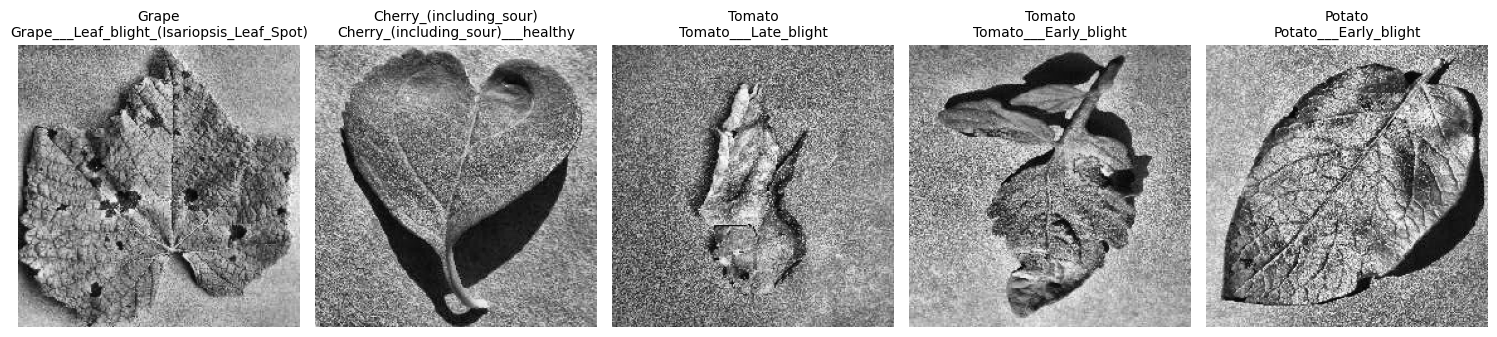

In [19]:
visualize_predictions_with_filenames(train_generator, num_images=5)

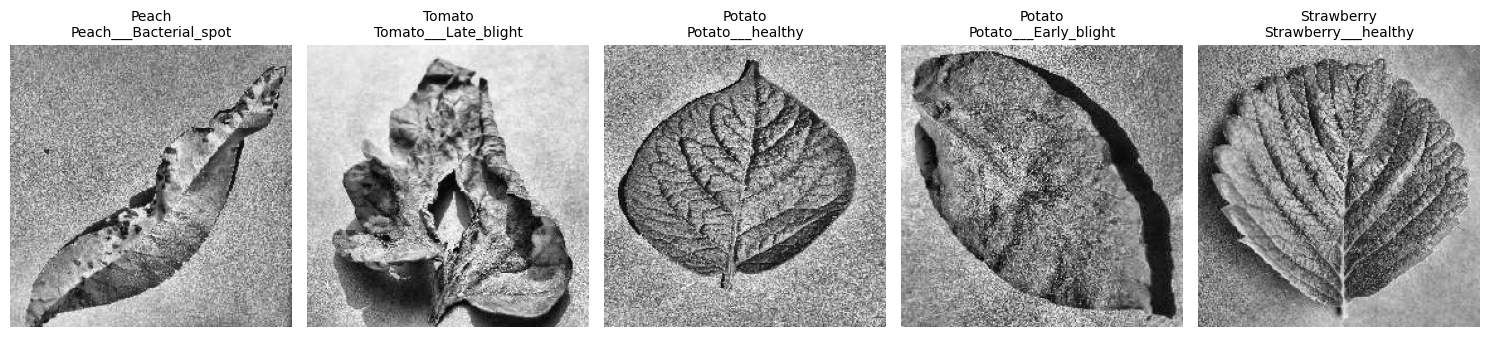

In [20]:
visualize_predictions_with_filenames(test_generator, num_images=5)

In [25]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate, BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf

IMG_SIZE = (224, 224)
NUM_CLASSES = 33
NUM_CROPS = 9

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
total_layers = len(base_model.layers)
trainable_layers_count = int(total_layers)

print(f"Unfreezed number of layers are {trainable_layers_count} and total number of layers is {total_layers}")

for layer in base_model.layers[:total_layers - trainable_layers_count]:
    layer.trainable = False


image_input = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = base_model(image_input)
x = GlobalAveragePooling2D()(x)

crop_input = Input(shape=(NUM_CROPS,))

combined = Concatenate()([x, crop_input])

x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(combined)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=[image_input, crop_input], outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Unfreezed number of layers are 154 and total number of layers is 154


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_4[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1289)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    660,480 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 33)        │      4,257 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,990,945 (11.41 MB)

 Trainable params: 2,955,553 (11.27 MB)

 Non-trainable params: 35,392 (138.25 KB)

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/kaggle/working/mobileNetV2_plantDisease.weights.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        save_freq='epoch',
        verbose=2
    )
]

epoch_model_callback = ModelCheckpoint(
    filepath='mobileNetV2_plantDisease_{epoch:02d}.keras',  
    save_best_only=False,                   
    save_weights_only=False,
    verbose=2                               
)

steps_per_epoch = np.ceil(len(train_gen.train_image_paths) / batch_size).astype(int)
validation_steps = np.ceil(len(train_gen.val_image_paths) / batch_size).astype(int)
print(f"steps per epoch for training: {steps_per_epoch}")
print(f"steps per epoch for validation: {validation_steps}")

steps per epoch for training: 1524
steps per epoch for validation: 381


In [27]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/20


I0000 00:00:1734082582.295220     100 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 484 bytes spill stores, 484 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 56 bytes spill stores, 56 bytes spill loads




Epoch 1: val_loss improved from inf to 3.59961, saving model to /kaggle/working/mobileNetV2_plantDisease.weights.h5
1524/1524 - 206s - 135ms/step - accuracy: 0.7764 - loss: 4.0179 - val_accuracy: 0.3612 - val_loss: 3.5996 - learning_rate: 5.0000e-04
Epoch 2/20

Epoch 2: val_loss improved from 3.59961 to 2.15868, saving model to /kaggle/working/mobileNetV2_plantDisease.weights.h5
1524/1524 - 145s - 95ms/step - accuracy: 0.8948 - loss: 0.7737 - val_accuracy: 0.5960 - val_loss: 2.1587 - learning_rate: 5.0000e-04
Epoch 3/20

Epoch 3: val_loss did not improve from 2.15868
1524/1524 - 144s - 94ms/step - accuracy: 0.9107 - loss: 0.6178 - val_accuracy: 0.4331 - val_loss: 3.3498 - learning_rate: 5.0000e-04
Epoch 4/20

Epoch 4: val_loss improved from 2.15868 to 1.32638, saving model to /kaggle/working/mobileNetV2_plantDisease.weights.h5
1524/1524 - 143s - 94ms/step - accuracy: 0.9325 - loss: 0.4864 - val_accuracy: 0.7481 - val_loss: 1.3264 - learning_rate: 5.0000e-04
Epoch 5/20

Epoch 5: val_lo

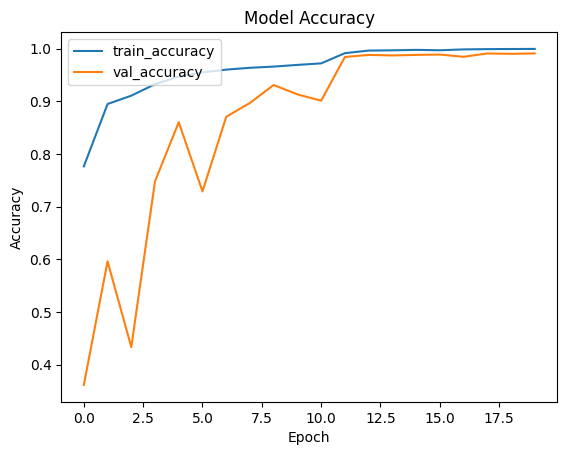

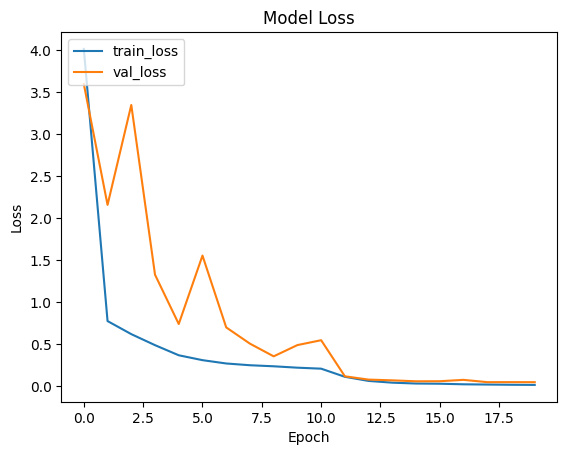

In [28]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.99      1.00       505
                                 Apple___Black_rot       0.99      1.00      1.00       499
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       443
                                   Apple___healthy       1.00      1.00      1.00       499
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       421
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       458
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.97      0.98       410
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       476
               Corn_(maize)___Northern_Leaf_Blight       0.97      0.98      0.98       476
                            Corn_(maize)___healthy       1.00      1.00      1.

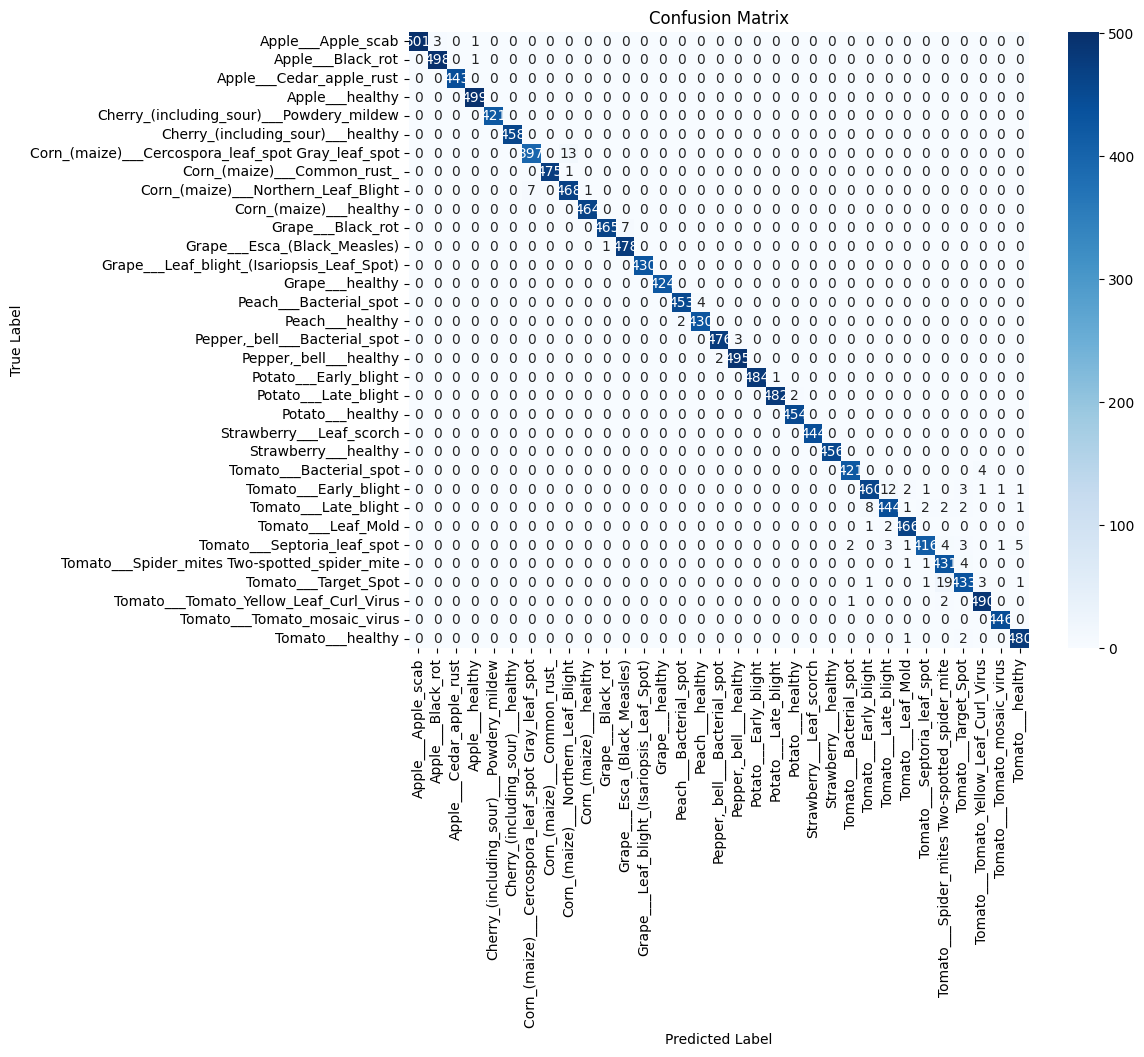

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = []
y_true = []

steps = np.ceil(len(test_gen.image_paths) / batch_size).astype(int)

for i in range(steps):
    (batch_x, batch_crop_onehot), batch_y = next(test_generator)
    batch_pred = model.predict([batch_x, batch_crop_onehot], verbose=0)
    batch_pred_classes = np.argmax(batch_pred, axis=1)
    
    # Get true class labels from the disease labels (not crop labels)
    batch_true_classes = np.argmax(batch_y, axis=1)
    
    y_pred.extend(batch_pred_classes)
    y_true.extend(batch_true_classes)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

report = classification_report(y_true, y_pred, target_names=test_gen.label_encoder.classes_)
print(report)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_gen.label_encoder.classes_, 
            yticklabels=test_gen.label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [30]:
y_pred[0]

15

In [31]:
y_pred = []
y_true = []

steps = np.ceil(len(test_gen.image_paths) / batch_size).astype(int)

for i in range(steps):
    (batch_x, batch_crop_onehot), batch_y = next(test_generator)
    batch_pred = model.predict([batch_x, batch_crop_onehot], verbose=0)
    y_pred.append(batch_pred)
    batch_true_classes = np.argmax(batch_crop_onehot, axis=1)
    y_true.extend(batch_true_classes)

y_pred = np.vstack(y_pred)  
y_true = np.array(y_true)

In [32]:
y_pred[0]

array([4.13733439e-08, 4.08411296e-08, 3.06709076e-08, 9.53453672e-09,
       1.40225387e-09, 5.39679523e-10, 2.31686585e-07, 3.99178042e-08,
       4.61825733e-09, 1.41850816e-08, 9.11893394e-10, 1.77945560e-06,
       6.77938317e-10, 2.66941509e-08, 3.44683997e-07, 9.99996543e-01,
       4.48663906e-09, 3.36013272e-07, 2.50880983e-10, 5.01166331e-10,
       2.69605692e-07, 4.63887995e-09, 9.24182828e-08, 2.63307796e-11,
       1.00660609e-08, 4.75777329e-09, 5.04562152e-08, 1.12524101e-10,
       2.47199985e-08, 7.79908689e-08, 1.66010032e-08, 1.50133900e-07,
       4.22353885e-09], dtype=float32)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ran

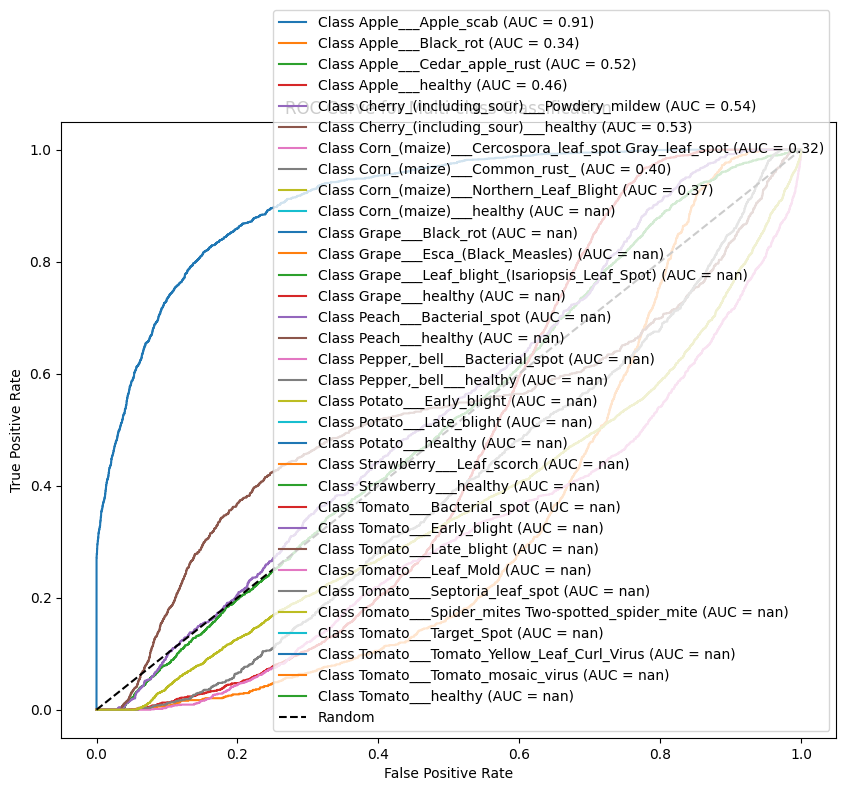

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_binarized = label_binarize(y_true, classes=np.arange(len(test_gen.label_encoder.classes_)))

fpr, tpr, roc_auc = {}, {}, {}

for i in range(y_pred.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(y_pred.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {test_gen.label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc='lower right')
plt.show()
